In [1]:
import mlflow

import torch
import torch.nn as nn
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from VAE.model import VAE
from VAE.data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2

device cuda is ready


In [3]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/ROBO/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=14)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_loader init


In [ ]:
train_loader = torch.load("VAE/train_loadet.pt")

In [4]:
len(train_loader)

419

In [5]:
loss_fn = nn.CrossEntropyLoss()

In [6]:
mlflow.set_tracking_uri("http://localhost:8080")

In [7]:
mlflow.set_experiment("/mlflow-pytorch-quickstart")

<Experiment: artifact_location='mlflow-artifacts:/938691871912139122', creation_time=1729683533514, experiment_id='938691871912139122', last_update_time=1729683533514, lifecycle_stage='active', name='/mlflow-pytorch-quickstart', tags={}>

In [8]:
from torch import nn, optim 

In [9]:
lr = 0.001
epochs = 2
latent_dim = 32

model = VAE(latent_dim, batch_size=BATCH_SIZE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
def train(epoch):
    #for epoch in range(1, epochs+1):
    x = next(iter(train_loader))
    model.train()
    print(f'Epoch {epoch} start')
        
    for batch_idx, data in enumerate(train_loader):
            data = data.to(DEVICE)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)

            loss.backward()
            optimizer.step()
            
    model.eval()
#    recon_img, _, _ = model(x[:1].to(DEVICE))
#    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
        
        #torch.save(train_loader, f'train_loadet_{epochs}.pt')
    torch.save(model, f'VAE_{epochs}.pt')


In [11]:
x = next(iter(train_loader))

In [12]:
input = x.detach().numpy()

In [13]:
import matplotlib.pyplot as plt

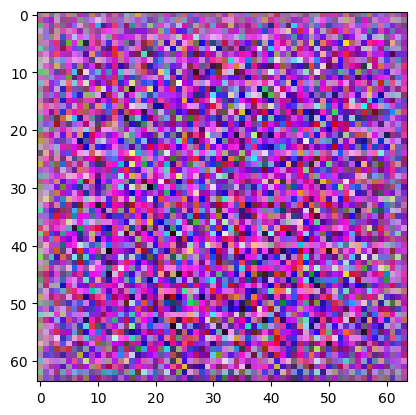

In [16]:
plt.imshow(model(torch.tensor(input)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0))

In [17]:
signature = mlflow.models.infer_signature(
    input,
    model(torch.tensor(input)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0),
)

In [188]:
def evaluation(dataloader, model, loss_fn, epochs):
    num_batches = len(dataloader)
    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for X in dataloader:
            Y = model(torch.tensor(X)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy()
            eval_loss += loss_fn(torch.tensor(Y), torch.tensor(X[0])).item()
    eval_loss /= num_batches
    mlflow.log_metric("eval_loss", f"{eval_loss:2f}", step=epochs)
    print(f"Avg loss: {eval_loss:2f} \n")

In [190]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": 1e-3,
        "batch_size": 32,
        #"loss_function": loss_fn.__class__.__name__,
        "metric_function": "CrossEntropyLoss",
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for t in range(1, epochs+1):
        train(t)
        #train(train_dataloader, model, loss_fn, metric_fn, optimizer, epoch=t)
        #evaluation(train_loader, model, loss_fn, epochs=t)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model", signature=signature)
    

Epoch 1 start


/tmp/ipykernel_420337/57576412.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = model(torch.tensor(X)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy()
/tmp/ipykernel_420337/57576412.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_loss += loss_fn(torch.tensor(Y), torch.tensor(X[0])).item()


Epoch 2 start


2024/10/23 16:54:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/23 16:54:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/23 16:54:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-zebra-456 at: http://localhost:8080/#/experiments/938691871912139122/runs/66e7533a908b42a7bbcd3ce58a8d231f.
2024/10/23 16:54:57 INFO mlflow.tracking._tracking_se

In [73]:
# X = model(torch.tensor(input)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy()
# Y = x.detach().cpu()

In [81]:
# X.shape

(3, 64, 64)

In [187]:
# loss_fn(torch.tensor(Y), torch.tensor(X)).item()

In [ ]:
with torch.no_grad():
    